# Chapter 3. Classification

在第1章中，我提到最常见的监督学习任务是回归（预测值）和分类（预测类别）。

在第2章中，我们探索了回归任务，使用线性回归、决策树和随机森林等各种算法预测住房值（将在后面的章节中进一步详细解释）。现在，我们将把注意力转向分类系统。

## MNIST

在本章中，我们将使用MNIST数据集，这是一套由高中生和美国人口普查局员工手写的数字小图像集。每张图像都标有它所代表的数字。这个集合已经过很多研究，以至于它通常被称为机器学习的 “hello world”：每当人们想出一个新的分类算法时，他们都想知道它在MNIST上的表现，任何学习机器学习的人迟早会处理这个数据集。

Scikit-Learn提供了许多辅助功能来下载流行的数据集。MNIST就是其中之一。以下代码获取MNIST数据集：

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Scikit-Learn加载的数据集通常具有类似的字典结构，包括以下内容：

- `DESCR` 描述数据集
- `data` array， 每行一个样本， 每列一个特征
- `target` array, 标签

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

有70,000张图像，每张图像有784个特征。这是因为每张图像都是28×28像素，每个特征仅代表一个像素的强度，从0（白色）到255（黑色）。让我们从数据集中看一下一位数字。您只需抓取样本的特征向量，将其重塑为28×28数组，并使用Matplotlib的
`imshow()` 功能：

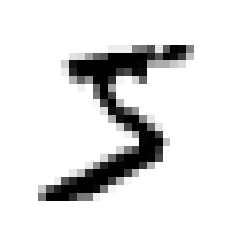

In [36]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline


some_digit = np.array(X)[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [4]:
y[0]

'5'

请注意，标签是一个字符串。大多数ML算法期望数字，所以让我们转换为整数：

In [5]:
y = y.astype(np.uint8)

为了让您感受到分类任务的复杂性，图3-1显示了MNIST数据集中的更多图像。

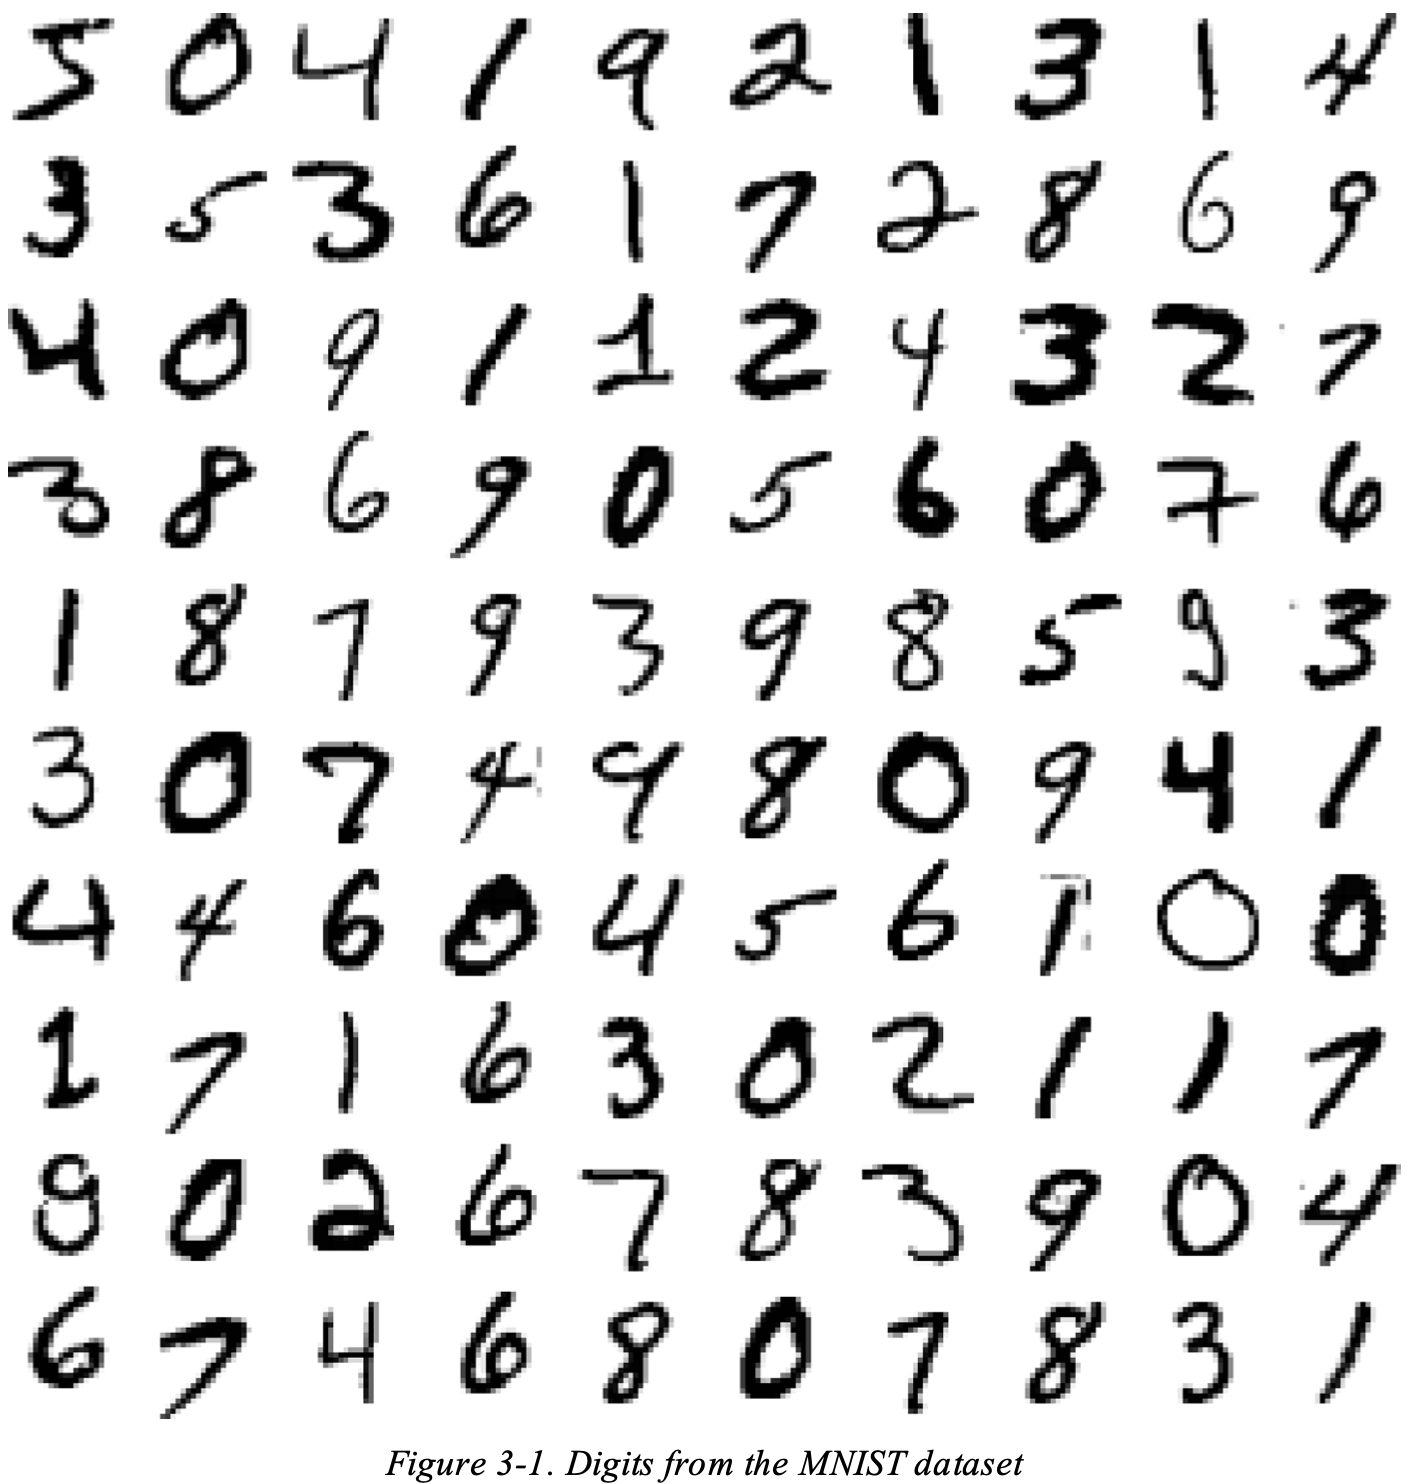

但是等等！在仔细检查数据之前，您应该始终创建一个测试集并将其放在一边。MNIST数据集实际上已经分为训练集（前60,000张图像）和测试集（最后10,000张图像）：

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

训练集已经为我们 shuffle 了，这很好，因为这保证了所有交叉验证 fold 都是相似的（您不希望一个 fold 缺少一些数字）。此外，一些学习算法对训练样本的顺序很敏感，如果连续获得许多类似的实例，它们的表现会很差。shuffle 数据集可确保这种情况不会发生。

## Training a Binary Classifier

让我们暂时简化问题，只尝试识别一个数字——例如数字5。这个 “5-detector” 将是一个二分类器的例子，能够区分两个类，5和 not-5。让我们为这个分类任务创建目标向量：

In [15]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

现在让我们选择一个分类器并对其进行训练。一个好的起点是使用随机梯度下降（SGD）分类器，使用Scikit-Learn的 `SGDClassifier` 类。该分类器的优点是能够有效地处理非常大的数据集。部分原因是SGD独立处理训练样本，一次一个（这也使SGD非常适合在线学习），我们稍后会看到。让我们创建一个 `SGDClassifier` , 并在整个训练集中对其进行训练：

In [16]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

> TIP: 在训练期间依赖随机性（因此得名“stochastic”）。如果您想要可重现的结果，您应该设置 `ramdom_state` 参数。

In [9]:
sgd_clf.predict([some_digit])

/Users/shawnd/miniforge3/envs/keras/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

分类器猜测此图像代表5(True)。看起来在这个特定例子下猜对了！现在，让我们评估一下这个模型的性能。

## Performance Measures

评估分类器通常比评估回归者要棘手得多，因此我们将把本章的大部分时间花在这个主题上。有很多性能指标可供选择，所以再喝一杯咖啡，准备学习许多新概念 和 acronyms！


### Measuring Accuracy Using Cross-Validation

评估模型的一个好方法是使用交叉验证，就像你在第2章中所做的那样。

> **IMPLEMENTING CROSS-VALIDATION**: 偶尔，您需要比 Scikit-Learn 提供的更多对交叉验证过程的控制。在这些情况下，您可以自己实现交叉验证。以下代码可以与Scikit-Learn的 `cross_val_score()` 功能大致相同，它打印的结果相同：
该类执行分层采样（如第2章所述），以生成包含每个类代表性比例的fold。在每次迭代中，代码都会创建分类器的克隆，训练在训练 fold 上克隆，并对测试 fold 进行预测。然后，它计算正确预测的数量，并输出正确预测的比率。


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

X_train = np.array(X_train)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


让我们使用该 `cross_val_score()` 函数来评估我们的 `SGDClassifier` 模型，使用三个 fold 的K折交叉验证。请记住，K折交叉验证意味着将训练集拆分为K fold（在这种情况下，为三个），在每个 fold 上进行预测和评估， 使用其他 fold 上的数据训练。

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

哇！所有交叉验证 fold 的准确率（正确预测的比率）高于93%？这看起来太棒了，不是吗？好吧，在你太兴奋之前，让我们看看一个非常愚蠢的分类器，它只是对“not-5”类中的每张图像进行分类：

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

没错，它的准确率超过90%！这只是因为只有大约10%的图像是5，所以如果你总是猜测图像不是5，那么大约90%的时间你是对的。Beats Nostradamus。

这说明了为什么准确性通常不是分类器的首选性能指标，特别是当您处理 skewed datasets 时（即当一些类比其他类更频繁时）。

## Confusion Matrix

评估分类器性能的更好方法是查看混淆矩阵。一般的想法是计算A类实例被归类为B类的次数。例如，要了解分类器将 5 与 3 的图像混淆的次数，请查看混淆矩阵的第五行和第三列。

要计算混淆矩阵，您首先需要有一组预测，以便将它们与实际目标进行比较。您可以对测试集进行预测，但让我们暂时保持不变（请记住，一旦您有准备启动的分类器，您只想在项目的最后使用测试集）。您可以使用 `cross_val_pred` 函数：

In [20]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

就像 `cross_val_score()` 函数一样， `cross_val_predict()` 执行K折交叉验证，但它不会返回评估分数，而是返回对每个测试 fold 所做的预测。这意味着您对训练集中的每个样本都有一个 clean 的预测（“clean”意味着预测是由一个在训练期间从未见过数据的模型做出的）。

现在，您已准备好使用 `confusion_matrix()` 函数。只需通过目标类(y_train_5)和预测类(y_train_pred)：

In [26]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[5731, 6564, 5608, 5540, 5483,  600, 5749, 5992, 7691, 5621],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0]])

混淆矩阵中的每行代表一个实际的类，而每列代表一个预测的类。该矩阵的第一行考虑了非-5图像（负类）: 其中53,057被正确归类为非-5（它们被称为 true negatives ），剩下的 1522 被错误分类为 5 (false positives)。 第二行考虑了5s（positive class）的图像：1,325被错误地归类为非-5（false negatives），其余4,096被正确归类为5s（true positives）。完美的分类器只有真正数和真负数，因此其混淆矩阵仅在主对角线上（从左上到右下角）具有非零值：

In [16]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

混淆矩阵为您提供了很多信息，但有时您可能更喜欢更简洁的指标。一个有趣的是  positive predictions 的准确性；这被称为分类器的 `precision`（方程3-1）。

$$precision = \frac{TP}{TP + FP}$$

TP 是 true positives 的数量，FP是 false positives 的数量。

获得 perfect precision 的一个微不足道的方法是做出一个 positive 的预测，并确保其正确（ precision = 1/1 = 100%）。但这并不很有用，因为分类器会忽略除一个正实例以外的所有正实例。因此，精度通常与另一个名为 recall 的指标一起使用，也称为 sensitivity 或  true positive rate（TPR）：这是分类器正确检测到的正实例的比率（方程3-2）。

$$recall = \frac{TP}{TP + FN}$$

FN 是 False negtives 的数量

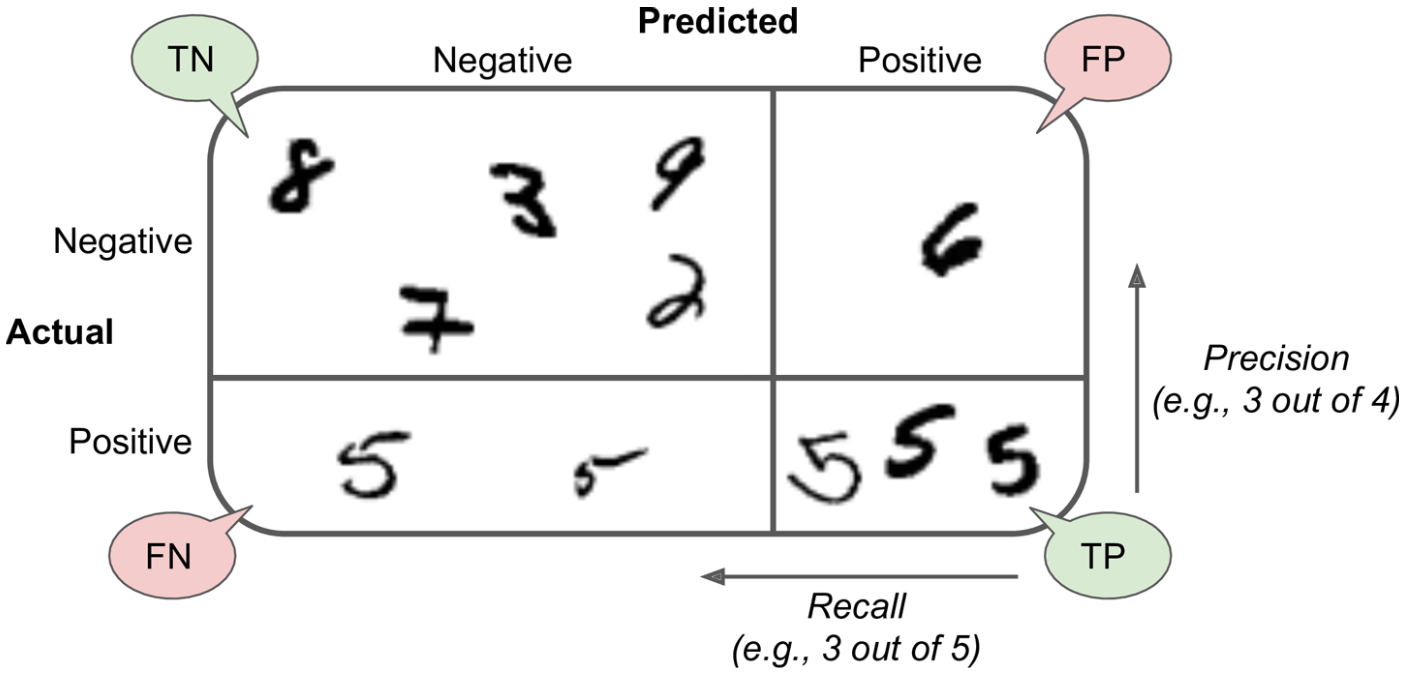


## Precision and Recall

Scikit-Learn提供了几个函数来计算分类器指标，包括 precision 和 recall：

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

现在，您的 5-detector 看起来不像您查看其准确性时那么闪亮。当它声称图像代表5时，只有72.9%的时间是正确的。此外，它只检测到 5s 的75.6%。

通常可以方便地将 precision 和 recall 组合成一个称为 F1 score 的指标，特别是如果您需要一种简单的方法来比较两个分类器。F1 score 是 precision 和 recall 的 harmonic mean（方程3-3）。regular mean 平等对待所有值，  harmonic mean 对低值的权重要大得多。因此，只有当 recall 和 precision 都很高时，分类器才能获得高 F1 score。

$$F_1 = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \times \frac{precision \times recall}{precision + recall} = \frac{TP}{TP + \frac{FN + FP}{2}}$$

In [50]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

F1分数更喜欢具有相似 precision 和 recall 的分类器。这并不总是你想要的：在某些情况下，你主要关心 precision，而在其他情况下，你真正关心 recall。 例如，如果您训练了分类器来检测对孩子安全的视频，您可能更喜欢拒绝许多好视频（低recall）但只保留安全视频（高 precision）的分类器，而不是 recall 高得多但允许产品中显示一些非常糟糕的视频的分类器（在这种情况下，您甚至可能想添加人工 pipeline 来检查分类器的视频选择）。 另一方面，假设您训练分类器在监控图像中检测商店小偷：分类器只有30%的精度，只要召回99%可能很好（当然，保安会收到一些虚假警报，但几乎所有商店小偷都会被抓到）。

不幸的是，你不能同时拥有它：提高 precision 会减少 recall，反之亦然。这被称为 precision/recall trade-off。

## Precision/Recall Trade-off

为了理解这种权衡，让我们看看 `SGDClassifier` 是如何做出分类决定的。对于每个实例，它根据决策函数计算分数。如果分数大于阈值， 它分配样本为正类； 否则分配它为负类。图3-3显示了从左边最低分数到右边最高分数的几个数字。假设决策阈值位于中央箭头（在两个5s之间）：您将在该阈值的右侧找到4个 True Positive（实际5s）和1个 False Positive（实际上是6）。因此，有了这个阈值，precision 为80%（满分5分）。但在6个实际5中，分类器只检测到4个，因此 recall 为67%（6个中有4个）。如果您提高阈值（将其移动到右侧箭头），False Positive（6）将变成 True Negative，从而提高 precision（在这种情况下高达100%），但一个 True positive 变成 False Negative，将 recall 降至50%。相反，降低阈值会增加recall 并降低 precision。


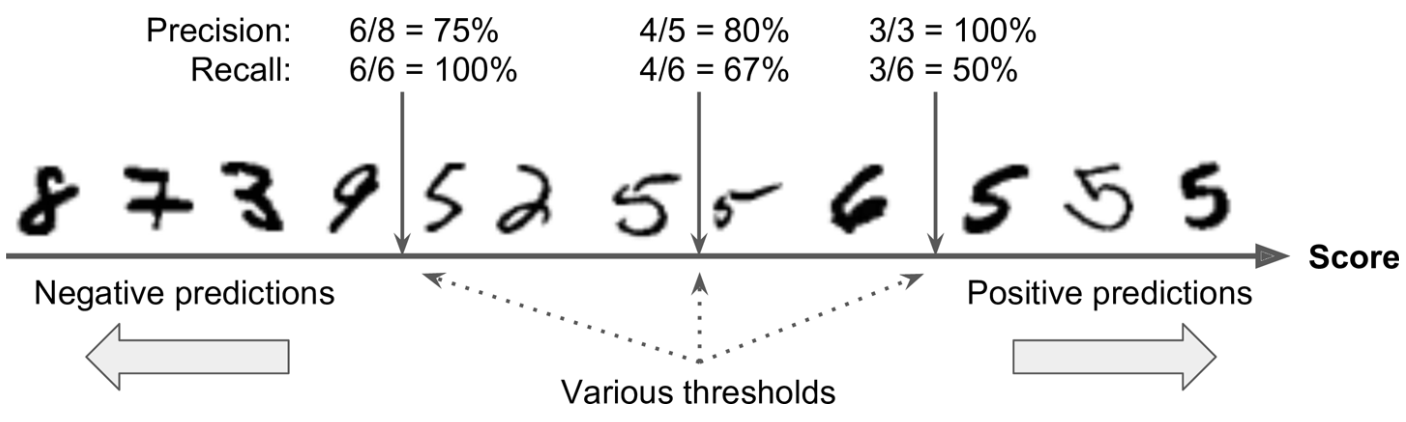

Scikit-Learn不允许您直接设置阈值，但它确实允许您访问用于进行预测的决策分数。作为替代 `precit()` 调用分类器的方法，您可以调用它的 `decision_function()` 方法，返回每个实例的分数，然后使用您想要根据这些阈值进行预测的任何阈值
分数:

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/Users/shawnd/miniforge3/envs/keras/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

`SGDClassifier` 使用等于0的阈值，所以之前的代码返回与 `predict()` 方法相同的结果（即 True）。让我们提高 threshold：

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

这证实了提高 threshold 可以减少 recall。图像实际上代表5，分类器在 theshold 为 0 时检测到它，但当 threshold 增加到8000时，它错过了它。

你如何决定使用哪个 threshold ？首先，使用 `coss_val_predict()` 函数以获取训练集中所有实例的分数，但这次指定您想要返回决策分数而不是预测：

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

使用这些分数，使用 `precision_recall_curve()` 函数计算所有可能 theshold 的 precision 和 recall：

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

最后，使用Matplotlib绘制 precision 和 recall 作为 theshold 的函数（图3-4）：

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], 'g-', label="Recall")

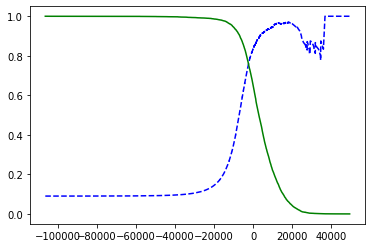

In [26]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

> Note:  你可能想知道为什么 precision 曲线比 recall 曲线更 bumpier 图3-4。原因是，当你提高 theshold 时，precision 有时会下降（尽管一般来说它会上升）。要了解原因，请回顾图3-3，注意当您从中央 theshold 开始并将其向右移动一位数字时会发生什么：precision 从 4/5（80%）下降到 3/4（75%）。另一方面，只有当 theshold 增加时，recall 才能下降，这解释了为什么它的曲线看起来很光滑。

选择良好 precision/recall trade-off 的另一种方法是直接根据 recall 绘制 precision，如图3-5所示（突出显示与之前的阈值相同）。

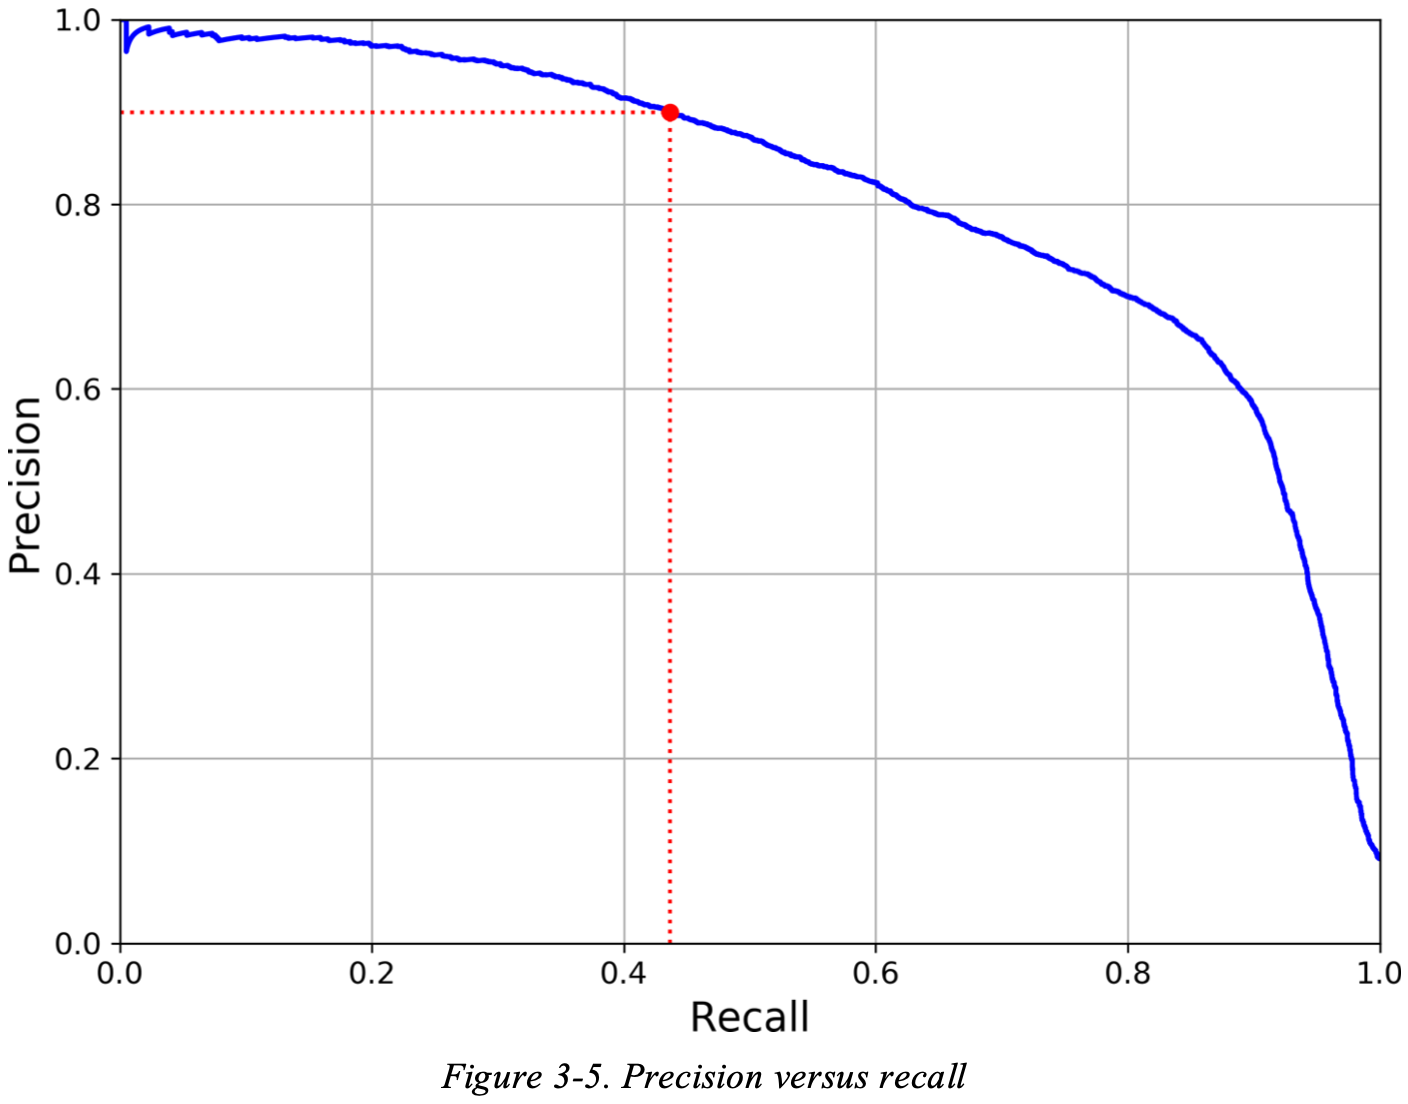

你可以看到，recall 在80%左右, precision 真的开始急剧下降。您可能需要在下降之前选择 precision/recall trade-off —— 例如，recall约为60%。当然，选择取决于你的项目。

假设你决定瞄准90%的 precision。你查找第一个 plot，发现你需要使用大约8000的 threshold。为了更高的 precision，您可以查找 90% precision 的最低 threshold（ `np.argmax()` 将为您提供最大值的第一个索引，在这种情况下，这意味着第一个 `True` 值）：

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439566

要进行预测（在目前设置的训练中），您可以运行以下代码，而不是调用分类器的 `predict()` 方法：

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

太好了，你有 90% precision 分类器！如您所见，几乎可以轻松创建您想要的任何 precision 的分类器：只需设置一个足够高的 theshold，您就完成了。但是等等，不要那么快。如果高精度分类器的 recall 率太低，就不是很有用！

> TIP: 如果有人说“让我们达到99%的precision”，你应该问，“什么 recall？”

## The ROC Curve

`receiver operating characteristic` (ROC）曲线是用于二分类器的另一种常用工具。它与 precision/recall 曲线非常相似，但 ROC 曲线没有绘制 precision 与 recall，而是将 True Positive rate（recall 的另一个名称）与 False Positive rate (FPR）绘制。FPR是被错误地归类为 positive 的 negative 实例的比率。它等于1- true negtive rate（TNR），这是正确归类为 negative 的 negative 实例的比率。TNR也被称为 `specificity`。 因此，ROC曲线绘制 sensitivity (recall) versus 1 – specificity。

要绘制ROC曲线，您首先使用 `roc_curve` 函数计算各种阈值的 TPR 和 FPR：

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

然后，您可以使用Matplotlib将 FPR 与 TPR 绘制。此代码生成图3-6中的绘图：

In [48]:
def plot_roc_curve(fpr, tpr, label=None):
    
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')

(3908,)
(3908,)


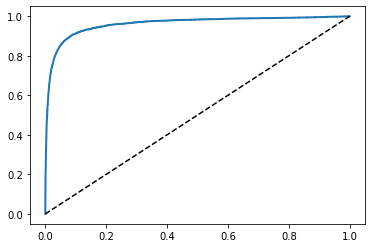

In [33]:
print(fpr.shape)
print(tpr.shape)
plot_roc_curve(fpr, tpr)
plt.show()

再次出现了权衡：recall（TPR）越高，分类器产生的 false positive（FPR）就越多。虚线表示纯随机分类器的ROC曲线；一个好的分类器尽可能远离该线（朝左上角）。

比较分类器的一种方法是测量曲线下的面积（AUC）。完美分类器的ROC AUC等于1，而纯随机分类器的ROC AUC等于0.5。Scikit-Learn提供了一个计算ROC AUC的函数：

In [34]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

> 由于 ROC曲线 与 precision/recall（PR）曲线非常相似，您可能想知道如何决定使用哪一个。根据经验，每当 Positive 类别很少 或 更关心 false positive 而不是 false negative 时，您应该更喜欢 PR 曲线。 否则，请使用ROC曲线。例如，看看之前的ROC曲线（以及ROC AUC分数），您可能会认为分类器真的很好。但这主要是因为与 negative 因素（非5）相比，positive（5s）很少。相比之下，PR 曲线清楚地表明，分类器有改进的余地（曲线可能更接近左上角）。


现在让我们训练一个 `RandomForestClassifier` 并比较它的ROC曲线 和 `SGDClassifier` 的 ROC AUC score。首先，您需要获得训练集中每个实例的分数。但是由于它工作的方式， `RandomForestClassifier` 没有 `decision_function()` 方法。 相反， 它有 `predict_proba()` 方法。 Scikit-Learn分类器通常有其中之一，或两者兼而有之。`predict_proba()` 方法返回一个数组，其中一行表示一个样本和一列表示一个类，每个数组都包含给定实例属于给定类的概率（例如，图像表示5的概率为70%）：

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

`roc_curve` 函数期望标签和分数，但您可以赋予它类概率，而不是分数。让我们用正类的概率作为分数:

In [36]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

现在你准备好绘制 ROC 曲线了。绘制第一个ROC曲线也很有用，看看它们是如何比较的（图3-7）：

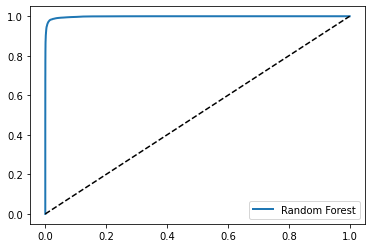

In [50]:
plt.close()
ax.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [51]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

尝试测量 precision 和 recall 分数：你应该找到 99.0% 的 precision 和 86.6% 的 recall。还不错！

您现在知道如何训练二分类器，为您的任务选择适当的指标，使用交叉验证评估分类器，选择适合您需求的 precision/recall trade-off，并使用 ROC曲线 和 ROC AUC分数 来比较各种模型。现在，让我们尝试检测的不仅仅是 5s。

## Multiclass Classification

二分类器区分两个类，而 `multiclass classifiers`（也称为 `multinomial classifiers`）可以区分两个以上的类。

一些算法（如SGD分类器、Random Forest分类器 和 naive Bayes classifiers）能够原生处理多个类。其他（如逻辑回归或支持向量机分类器）是严格的二分类器。但是，您可以使用各种策略来使用多个二进制分类器进行多类分类。

创建一个可以将数字图像分类为10个类（从0到9）的系统的一种方法是训练10个二进制分类器，每个数字一个（0探测器、1探测器、2探测器等）。然后，当您想对图像进行分类时，您将从该图像的每个分类器中获得决策分数，并选择分类器输出最高分数的类。这被称为 one-versus-the-rest (OvR) 策略（也称为  one- versus-all）。

另一种策略是为每对数字训练一个二分类器：一个用于区分0s和1s，另一个用于区分0s和2s，另一个用于区分1s和2s，等等。这被称为 `one-versus-one`(OvO) 策略。如果有 N 个类，您需要训练 `N×(N-1)/2` 个分类器。对于MNIST问题，这意味着训练45个二分类器！当您想对图像进行分类时，您必须在所有45个分类器中运行图像，并查看哪个类赢得最多的决斗。OvO的主要优势是，每个分类器只需要在它必须区分的两个类别的训练集上进行训练。

一些算法（如支持向量机分类器）随着训练集大小 scale poorly。对于这些算法，OvO是首选，因为在小型训练集上训练许多分类器比在大型训练集上训练少数分类器更快。然而，对于大多数二分类算法，OvR是首选。

Scikit-Learn 检测您何时尝试将二分类算法用于多类分类任务，并根据算法自动运行 OvR 或 OvO。让我们试一下支持向量机分类器， 使用 `sklearn.svm.SVC` 类：

In [7]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

/Users/shawnd/miniforge3/envs/keras/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

这个代码在使用原始 0 到 9 (`y_train`)的目标类别在训练集上训练 `SVC`， 而不是 5-versus-the-rest 目标类别(`y_train_5`)。 然后它做出预测（在这种情况下是正确的预测）。在 hood 下，Scikit-Learn实际上使用了OvO策略：它训练了45个二分类器，获得了图像的决定分数，并选择了赢得最多决斗的类别。

如果您调用 `decision_function()` 方法，您将看到它每个实例返回 10 个分数（而不仅仅是 1 个分数）。这是每个类别的一个分数：

In [53]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [54]:
np.argmax(some_digit_scores)

5

In [55]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [56]:
svm_clf.classes_[5]

5

> WARNING： 当分类器经过训练时，它会将目标类列表存储在其 `classes_` 属性，按值排序。在这种情况下，每个类在 `classes_` 索引数组中的索引方便地匹配类本身（例如，索引5的类恰好是类别5），但总的来说，你不会那么幸运。
 
如果您想强制Scikit-Learn使用 one-versus-one 或 one-versus-the-rest，您可以使用 `OneVsOneClassifier` 或
`OneVsRestClassifier` 类。只需创建一个实例并将分类器传递给其构造函数（它甚至不必是二分类器）。例如，这个代码
使用OvR策略创建一个多类分类器，基于 `SVC`：

In [8]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

/Users/shawnd/miniforge3/envs/keras/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/shawnd/miniforge3/envs/keras/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/shawnd/miniforge3/envs/keras/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/shawnd/miniforge3/envs/keras/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/shawnd/miniforge3/envs/keras/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/shawnd/miniforge3/envs/keras/lib/python3.8/

array([5], dtype=uint8)

In [12]:
len(ovr_clf.estimators_)

10

训练一个 `SGDClassifier` (或者一个 `RandomForestClassifier`) 同样容易:

In [17]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/Users/shawnd/miniforge3/envs/keras/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

这次 Scikit-Learn 不必运行 OvR 或 OvO，因为SGD分类器可以直接将实例分类为多个类。`decision_function()` 方法每个类返回一个值。 让我们看看SGD分类器分配给每个类的分数：

In [18]:
sgd_clf.decision_function([some_digit])

/Users/shawnd/miniforge3/envs/keras/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

你可以看到，分类器对其预测相当有信心：几乎所有的分数基本上都是负数，而类别 5 的分数为2412.5。该模型对类别略有疑问，得分为573.5分。现在你当然想评估这个分类器。像往常一样，你可以使用交叉验证。使用 `cross_val_score` 函数来评估 `SGDClassifier` 的准确率：

In [23]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

它在所有测试 fold 上都超过84%。如果你使用随机分类器，你会得到10%的准确率，所以这不是一个糟糕的分数，但你仍然可以做得更好。只需缩放输入（如第2章所述），即可将准确性提高到89%以上：

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

如果这是一个真实的项目，您现在可以按照机器学习项目清单中的步骤操作（请参阅附录B）。您将探索数据准备选项，尝试多个模型（入围最佳模型和使用 `GridSearchCV` 微调他们的超参数），并尽可能自动化。在这里，我们将假设您已经找到了一个有前途的模型，并希望找到改进它的方法。一种方法是分析它所犯的错误类型。

首先，看看混淆矩阵。您需要使用 `cross_val_predict()` 函数进行预测，然后调用 `confusion_matrix()` 函数，就像你之前所做的那样：

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [27]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

很多数字。看图像通常更方便, 使用 Matplotlib 的 `matshow()` 函数表示混淆矩阵：

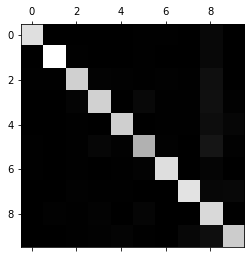

In [28]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

这个混淆矩阵看起来相当不错，因为大多数图像都在主对角线上，这意味着它们被正确分类。 5s看起来比其他数字略暗，这可能意味着数据集中 5s 的图像更少，或者分类器在 5s 上的表现不如其他数字。事实上，您可以验证两者都是这样。

让我们把 plot 集中在错误上。首先，您需要将混淆矩阵中的每个值除以相应类中的图像数量，以便您可以比较错误率，而不是绝对错误数量（这将使 abundant classes 看起来不公平地糟糕）：

In [29]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

用零填充对角线，只保留错误，并绘制结果：

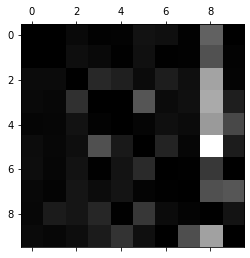

In [30]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

您可以清楚地看到分类器犯的错误类型。请记住，行代表实际类，而列代表预测类。8类的列相当明亮，它告诉你许多图像被错误地归类为8s。然而，第8类的行并没有那么糟糕，告诉你实际的8s通常被正确地归类为8s。如您所见，混淆矩阵不一定是对称的。您还可以看到，3s和5s经常混淆（双向）。


分析混淆矩阵通常可以让您深入了解改进分类器的方法。看看这个plot，看来你的努力应该花在减少fake 8 上。例如，您可以尝试为看起来像 8s（但不是8s）的数字收集更多训练数据，以便分类器可以学习将它们与真正的 8s 区分开来。或者，您可以设计有助于分类器的新函数——例如，编写算法来计算闭环的数量（例如，8 有 2，6 有1，5没有）。或者，您可以对图像进行预处理（例如，使用Scikit-Image、Pillow 或 OpenCV），使一些图案（如闭环）更突出。

分析单个错误也可以是深入了解分类器正在做什么以及为什么失败的好方法，但它更困难，也更耗时。例如，让我们绘制 3s 和 5s的示例（函数 `plot_digits()` 使用 Matplotlib 的 `imshow()` 函数：

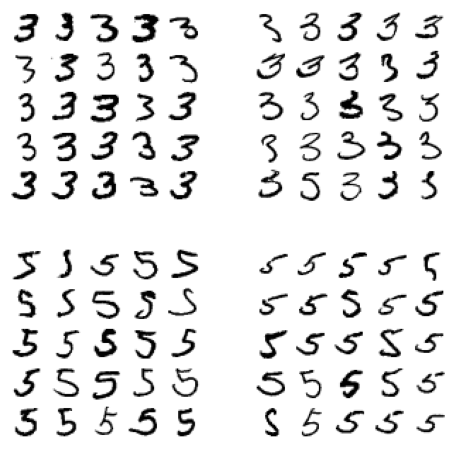

In [66]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

X_train = np.array(X_train) 
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

左侧的两个 5×5 块显示数字被归类为 3s，右侧的两个 5×5 块显示被归类为 5s 的图像。分类器出错的一些数字（即左下角和右上角的块）写得如此糟糕，以至于即使是人类也会难以对其进行分类（例如，第一行和第二列中的5看起来确实像写得不好的3）。然而，对我们来说，大多数错误分类的图像似乎都是明显的错误，很难理解为什么分类器会它犯了错误。原因是我们使用了一个简单的`SGDClassifier`，即线性模型。 它所做的就是为每一个像素分配一个权重，当它看到一个新图像时，它只是将加权的像素强度加起来，从而得到每个类的分数。 因此，由于3s和5s仅相差几像素，该模型很容易混淆它们。

3s 和 5s 的主要区别是连接顶线到底部弧的小线的位置。如果您绘制一个3，结略微向左移动，分类器可能会将其归类为5，反之亦然。换句话说，这个分类器对图像移位和旋转非常敏感。因此，减少 3/5 混淆的一种方法是对图像进行预处理，以确保它们居中良好且不会太旋转。这可能也有助于减少其他错误。

## Multilabel Classification

到目前为止，每个实例一直只分配给一个类。在某些情况下，您可能希望分类器为每个实例输出多个类。考虑一个人脸识别分类器：如果它能识别同一张照片中的几个人，它应该怎么做？它应该给每个能识别的人贴上一个标签。假设分类器经过训练，可以识别三张脸，Alice, Bob, and Charlie。然后，当分类器显示爱丽丝和查理的图片时，它应该输出 `[1，0，1]`（意思是，“Alice yes, Bob no, Charlie yes”）。这种输出多个二标签的分类系统称为多标签分类系统。

我们目前还没有开始人脸识别，但让我们看看一个更简单的例子，只是为了说明：

In [47]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

此代码创建一个数组，为每个数字图像包含两个目标标签：第一个表示是否是大的数字 (7, 8, 9), 第二个表示是否是奇数。 下面一行创建一个 `KNeighborsClassifier` 实例(其支持多标签分类)， 然后我们训练它。 现在可以做预测， 并且注意到它输出两个标签：

In [48]:
knn_clf.predict([some_digit])

array([[False,  True]])

而且它做对了！数字5确实不是大的数字并且是奇数。 有很多方法可以评估多标签分类器，选择正确的指标确实取决于您的项目。一种方法是测量每个标签（或前面讨论的任何其他二分类器指标）的F1 score，然后简单地计算平均分数。此代码计算所有标签的平均F1 score：

In [51]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

然而，这假设所有标签都同等重要，但事实可能并非如此。特别是，如果你的 Alice 的照片比 Bib 或 Charlie 的照片多得多，你可能想更重视分类器对 Alice 照片的分数。一个简单的选择是给每个标签一个与其 `support` 相等的权重（即带有该目标标签的实例数量）。只需在前面的代码中设置 `average="weighted"`。

## Multioutput Classification

我们将在这里讨论的最后一种分类任务称为 multioutput–multiclass 分类（或简单的多输出分类）。它只是多标签分类的推广，其中每个标签可以是多类（即它可以有两个以上的可能值）。它只是多标签分类的推广，其中每个标签可以是多类（即它可以有两个以上的可能值）。

为了说明这一点，让我们建立一个消除图像噪声的系统。它将以嘈杂的数字图像作为输入，并将（希望）输出干净的数字图像，表示为像素强度阵列，就像 MNIST 图像一样。请注意，分类器的输出是多标签（每个像素一个标签），每个标签可以有多个值（像素强度范围从0到255）。因此，它是多输出分类系统的一个例子。

> NOTE: 分类和回归之间的界限有时很模糊，例如在本例中。可以说，预测像素强度更类似于回归而不是分类。此外，多输出系统不限于分类任务；您甚至可以有一个系统，每个实例输出多个标签，包括类标签和值标签。

让我们从创建训练和测试集开始，方法是在MNIST图像上使用NumPy的 `randint` 函数增加噪声。目标图像是原始图像：

In [55]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

让我们看看测试集中的图像（是的，我们正在查看测试数据，所以你现在应该皱眉头）：

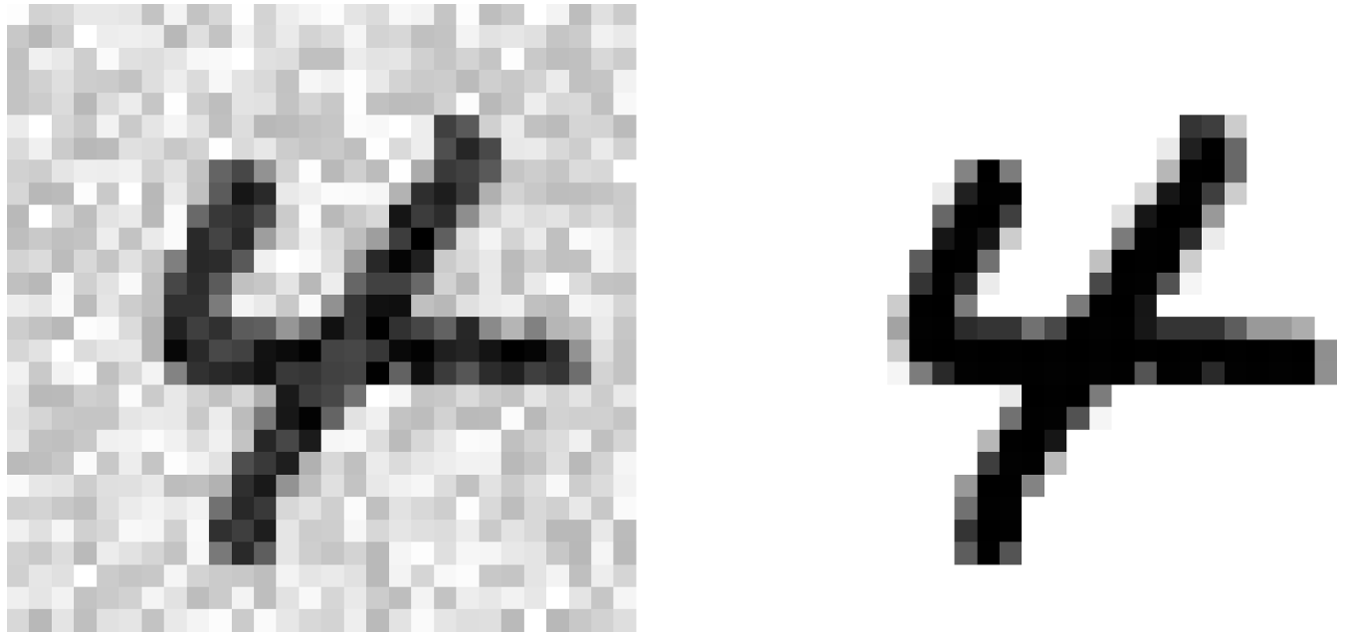

左边是嘈杂的输入图像，右边是干净的目标图像。现在，让我们训练分类器，让它清理这张图片：

(1, 784)


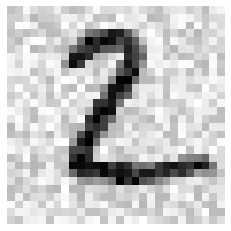

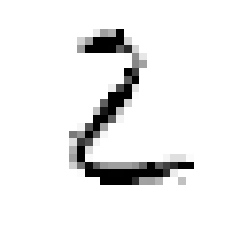

In [67]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([np.array(X_test_mod)[1]])
print(clean_digit.shape)
plot_digits(np.array(X_test_mod)[1].reshape(1, -1))
plt.show()
plot_digits(clean_digit)
plt.show()

看起来离目标足够近！我们的分类之旅到此结束。您现在应该知道如何为分类任务选择良好的指标，选择适当的 precision/recall trade-off，比较分类器，以及更普遍地为各种任务构建良好的分类系统。